Nomes: Debora Freitas Lobão; Giovanna Arcoverde de Sousa Constâncio

A seguir, importamos as bibliotecas que serão usadas para analise dos dados e estilização (seaborn).

Após as importações, temos o set do arquivo que importamos e definição de uma váriavel com o .csv importado para que possamos usá-lo para análise.

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
sns.set(style='whitegrid', palette='Set2', font_scale=1.2)

local_zip = 'titanic.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('titanic')
zip_ref.close()

train_data = pd.read_csv('titanic/train.csv')
train_data.head()

In [ ]:
test_data = pd.read_csv('titanic/test.csv')
test_data.head()

Aqui imprimimos o número de colunas e linhas dos datasets de treino e teste.

In [ ]:
print('Shape of train dataset {}'.format(train_data.shape))
print('Shape of test dataset {}'.format(test_data.shape))

Agora estamos descrevendo os dados, incluindo aqueles absolutos.

In [ ]:
train_data.describe(include='all') 

Aqui estamos tentando descobrir se Jack estava registrado no navio. No caso desta base de dados ele não foi constatado, apenas existe um Jackson.

In [ ]:
train_data.describe(include='all')
train_data[train_data["Name"].str.contains('Jack', na=False)]

Nesta parte do código, vemos se os dados são consistentes, vendo se algo está duplicado ou faltando;

No caso ele indica que não há dados duplicados, mas que existem dados nulos.

In [ ]:
print('\nNull Values in Training \n{}'.format(train_data.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_data.isnull().sum()))

print('\nDuplicated values in train {}'.format(train_data.duplicated().sum()))
print('Duplicated values in test {}'.format(test_data.duplicated().sum()))

Aqui pegamos a moda dos valores das tarifas, ou seja, os valores mais comuns, para preencher os 2 dados que ficaram nulos.

In [ ]:
print('Embarkation per ports \n{}'.format(train_data['Embarked'].value_counts()))

train_data['Embarked'].fillna(value='S', inplace=True)
test_data['Fare'].fillna(value=test_data.Fare.mean(), inplace=True)

print('Embarkation per ports after filling \n{}'.format(train_data['Embarked'].value_counts()))

Agora para preencher as idades dividimos os dados pelos pronomes de tratamento (as siglas para senhorita, senhor, etc. em inglês) e fazemos a média de cada uma dessas categorias pra preencher as "células" vazias;
esses dados são exibidos no final de acordo com os pronomes;

Ao final, geramos um mapa de calor para saber a quantidade de dados vazios que restaram, no caso apenas da cabine (já que as outras duas colunas ja foram tratadas e preenchidas)

In [ ]:
mean_age_miss = round(train_data[train_data["Name"].str.contains('Miss.', na=False)]['Age'].mean())
mean_age_mrs = round(train_data[train_data["Name"].str.contains('Mrs.', na=False)]['Age'].mean())
mean_age_mr = round(train_data[train_data["Name"].str.contains('Mr.', na=False)]['Age'].mean())
mean_age_master = round(train_data[train_data["Name"].str.contains('Master.', na=False)]['Age'].mean())

#mean_age_miss = train_data[train_data["Name"].str.contains('Miss.', na=False)]['Age'].mean().round()
#mean_age_mrs = train_data[train_data["Name"].str.contains('Mrs.', na=False)]['Age'].mean().round()
#mean_age_mr = train_data[train_data["Name"].str.contains('Mr.', na=False)]['Age'].mean().round()
#mean_age_master = train_data[train_data["Name"].str.contains('Master.', na=False)]['Age'].mean().round()

print('Mean age of Miss. title {}'.format(mean_age_miss))
print('Mean age of Mrs. title {}'.format(mean_age_mrs))
print('Mean age of Mr. title {}'.format(mean_age_mr))
print('Mean age of Master. title {}'.format(mean_age_master))

def fill_age(name_age):
    
    name = name_age[0]
    age = name_age[1]
    
    if pd.isnull(age):
        if 'Mr.' in name:
            return mean_age_mr
        if 'Mrs.' in name:
            return mean_age_mrs
        if 'Miss.' in name:
            return mean_age_miss
        if 'Master.' in name:
            return mean_age_master
        if 'Dr.' in name:
            return mean_age_master
        if 'Ms.' in name:
            return mean_age_miss
    else:
        return age

train_data['Age'] = train_data[['Name', 'Age']].apply(fill_age,axis=1)
test_data['Age'] = test_data[['Name', 'Age']].apply(fill_age,axis=1)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.heatmap(train_data.isnull(),cmap='copper', ax=ax1)
sns.heatmap(train_data.isnull(), cmap='copper', ax=ax2)
plt.tight_layout()

Definimos então que quando a "célula" for nula, definiremos a cabine como X

In [ ]:
train_data['Cabin'] = pd.Series(['X' if pd.isnull(ii) else ii[0] for ii in train_data['Cabin']])
test_data['Cabin'] = pd.Series(['X' if pd.isnull(ii) else ii[0] for ii in test_data['Cabin']])

Aqui fazemos um gráfico para saber as taxas de cada tipo de cabine, lembrando que no caso o X é relativo aos dados nulos na base.

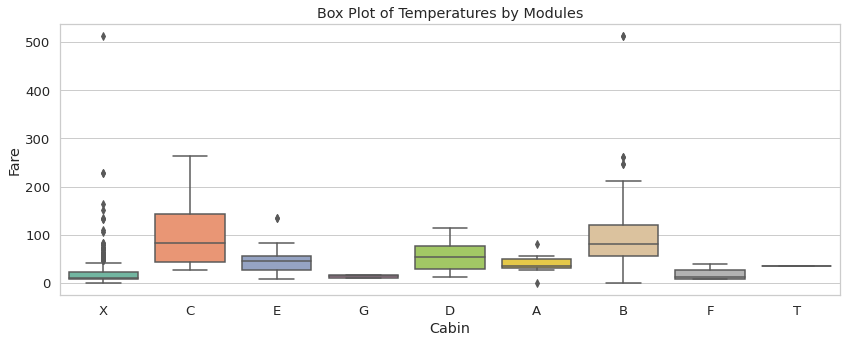

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Box Plot of Temperatures by Modules')
sns.boxplot(x='Cabin',y='Fare',data=train_data, palette='Set2')
plt.tight_layout()

Aqui definimos a média de tarifa pra as cabines que possuem mais dados.

In [ ]:
print('Mean Fare of Cabin B {}'.format(train_data[train_data['Cabin']=='B']['Fare'].mean()))
print('Mean Fare of Cabin C {}'.format(train_data[train_data['Cabin']=='C']['Fare'].mean()))
print('Mean Fare of Cabin D {}'.format(train_data[train_data['Cabin']=='D']['Fare'].mean()))
print('Mean Fare of Cabin E {}'.format(train_data[train_data['Cabin']=='E']['Fare'].mean()))

Mean Fare of Cabin B 113.50576382978724
Mean Fare of Cabin C 100.15134067796612
Mean Fare of Cabin D 57.24457575757576
Mean Fare of Cabin E 46.026693749999986


Após considerar as médias, retiramos os outliers da classe x e colocamos nas suas respectivas classes, para uma maior consistência de dados.

In [ ]:
def reasign_cabin(cabin_fare):
    
    cabin = cabin_fare[0]
    fare = cabin_fare[1]
    
    if cabin=='X':
        if (fare >= 113.5):
            return 'B'
        if ((fare < 113.5) and (fare > 100)):
            return 'C'
        if ((fare < 100) and (fare > 57)):
            return 'D'
        if ((fare < 57) and (fare > 46)):
            return 'D'
        else:
            return 'X'
    else:
        return cabin

Agora geramos um gráfico atualizado com os valores das tarifas atribuídas a X - nota-se que a variação mudou e há menos outliers (as bolinhas), já que foram encaixadas nas classes.

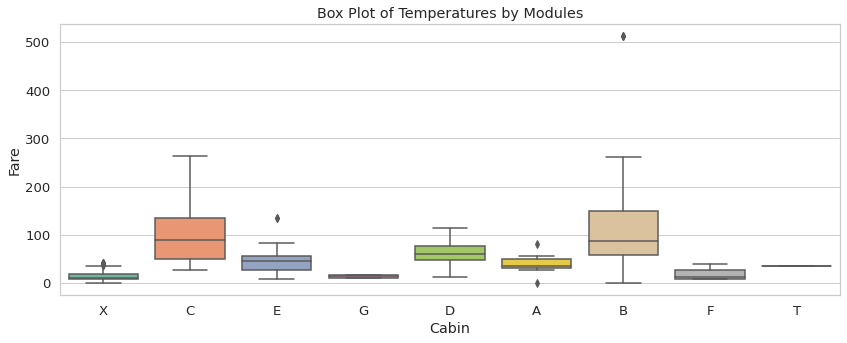

In [ ]:
train_data['Cabin'] = train_data[['Cabin', 'Fare']].apply(reasign_cabin, axis=1)
test_data['Cabin'] = test_data[['Cabin', 'Fare']].apply(reasign_cabin, axis=1)

plt.figure(figsize=(12,5))
plt.title('Box Plot of Temperatures by Modules')
sns.boxplot(x='Cabin',y='Fare',data=train_data, palette='Set2')
plt.tight_layout()

Após todo o tratamento dos dados, podemos ver que nenhuma coluna está vazia, permitindo uma melhor análise.

In [ ]:
print('\nNull Values in Training \n{}'.format(train_data.isnull().sum()))


Null Values in Training 
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


A partir daqui, são feitas análises extras para incrementar o estudo;

A seguir são feitos gráficos em barra mostrando a quantidade de parentes entre os tripulantes, sendo respectivamente entre irmãos, conjuges, pais e filhos e distribuição entre classes.

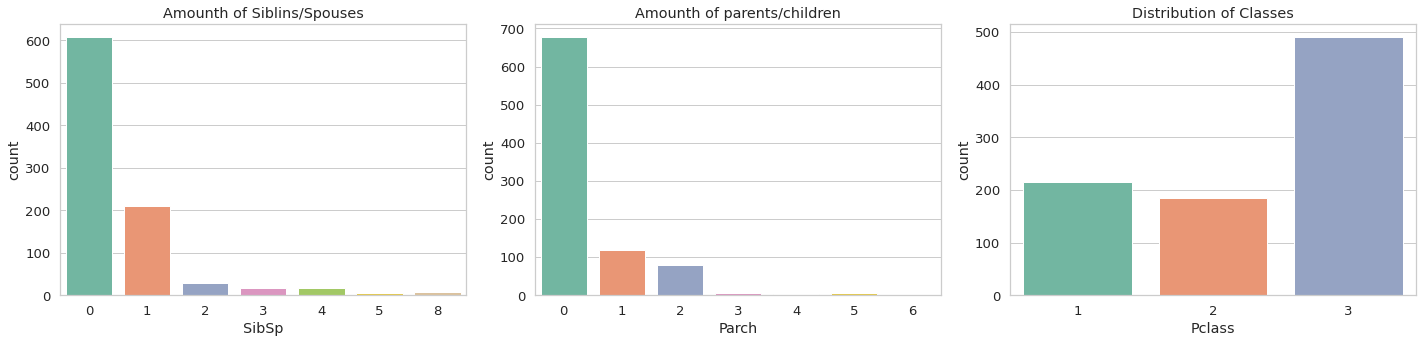

In [ ]:
fig, axx = plt.subplots(1, 3, figsize=(20,5))
axx[0].set_title('Amounth of Siblins/Spouses')
sns.countplot(x='SibSp', data=train_data, ax=axx[0])
axx[1].set_title('Amounth of parents/children')
sns.countplot(x='Parch', data=train_data, ax=axx[1])
axx[2].set_title('Distribution of Classes')
sns.countplot(x='Pclass', data=train_data, ax=axx[2])
plt.tight_layout()

Aqui são separadas as pessoas que viajam sozinhas das que estão com seus parentes, baseado nos atributos do SibSp e Parch, e também no tamanho da família.

Então são criados gráficos a partir dos sobreviventes, quantidade de pessoas:

In [ ]:
def create_alone_feature(SibSp_Parch):
    if (SibSp_Parch[0]+SibSp_Parch[1])==0:
        return 1
    else:
        return 0

In [ ]:
train_data['Alone'] = train_data[['SibSp','Parch']].apply(create_alone_feature, axis=1)
train_data['Familiars'] = 1 + train_data['SibSp'] + train_data['Parch']

test_data['Alone'] = test_data[['SibSp','Parch']].apply(create_alone_feature, axis=1)
test_data['Familiars'] = 1 + test_data['SibSp'] + test_data['Parch']

Através dos gráficos percebemos que a maior parte das pessoas morreram no incidente. A maior parte dos sobreviventes eram composto por mulheres, e aqueles que morreram, em sua grande maioria, faziam parte da classe baixa.

In [ ]:
fig, axx = plt.subplots(2, 3, figsize=(20,10))
axx[0,0].set_title('Survivors')
sns.countplot(x='Survived', data=train_data, ax=axx[0,0])
axx[0,1].set_title('Survivors by Sex')
sns.countplot(x='Survived', hue='Sex', data=train_data, ax=axx[0,1])
axx[0,2].set_title('Survivors by Pclass')
sns.countplot(x='Survived', hue='Pclass', data=train_data, ax=axx[0,2])
axx[1,0].set_title('Accompanied survivors')
sns.countplot(x='Survived', hue='Alone', data=train_data, ax=axx[1,0])
axx[1,1].set_title('Accompanied survivors')
sns.countplot(x='Familiars', hue='Survived', data=train_data, ax=axx[1,1])
axx[1,2].set_title('Alone members by Pclass')
sns.countplot(x='Pclass', hue='Alone', data=train_data, ax=axx[1,2])
plt.tight_layout()

Agora iremos ver as idades e as tarifas dos sobreviventes.

In [ ]:
fig, axx = plt.subplots(1, 3, figsize=(20,5))
axx[0].set_title('Age of Survivors')
sns.boxplot(x='Survived', y='Age', data=train_data, ax=axx[0])
axx[1].set_title('Survivors by Sex')
sns.boxplot(x='Survived', y='Age', hue='Sex', data=train_data, ax=axx[1])
axx[2].set_title('Survivors by Sex')
sns.boxplot(x='Survived', y='Age', hue='Pclass', data=train_data, ax=axx[2])
plt.tight_layout()

Os que sobreviveram eram um pouco mais jovens do que os que morreram, e as pessoas de  classe alta eram mais velhas do que as de baixa classe. Apesar de existir uma correlação entre tarifa e sobreviventes, não está sendo levado em conta categorias.

In [ ]:
fig, axx = plt.subplots(1, 2, figsize=(16,5))
axx[0].set_title('Distribution of Fare of Dead ones')
sns.distplot(a=train_data[train_data['Survived']==0]['Fare'], ax=axx[0], bins=30)
axx[1].set_title('Distribution of Fare of Survived ones')
sns.distplot(a=train_data[train_data['Survived']==1]['Fare'], ax=axx[1], bins=30)
plt.tight_layout()

Sendo assim, faremos o mapeamento dos dados nas colunas Sex e Embaerked.

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(train_data.corr(), annot=True)
plt.tight_layout()

Aqui usamos a função map() do pandas para mapear as categorias em números.

Considerando que as mulheres fazem parte da maioria dos sobreviventes, foi definido 1 para elas e 0 para os homens, assim conseguiremos criar uma correlação positiva.

In [ ]:
categories = {"female": 1, "male": 0}
train_data['Sex']= train_data['Sex'].map(categories)
test_data['Sex']= test_data['Sex'].map(categories)

In [ ]:
categories = {"S": 1, "C": 2, "Q": 3}
train_data['Embarked']= train_data['Embarked'].map(categories)
test_data['Embarked']= test_data['Embarked'].map(categories)

categories = train_data.Cabin.unique()
train_data['Cabin'] = train_data.Cabin.astype("category").cat.codes
test_data['Cabin'] = test_data.Cabin.astype("category").cat.codes

In [ ]:
plt.figure(figsize=(14,8))
sns.heatmap(train_data.corr(), annot=True)
plt.tight_layout()

Aqui estamos tirando as características desnecessárias como nome, o ticket e o id do passageiro.

In [ ]:
train_data = train_data.drop(['Name','Ticket','PassengerId'], axis=1)
test_data = test_data.drop(['Name','Ticket','PassengerId'], axis=1)
train_data.head()

Agora vamos normalizar os dados usanso a biblioteca MixMaxScaler do Scikit Learn, para que então a convergencia do Machine Learning seja mais rápida.

Assim importamos a biblioteca e fazemos um "drop" na label.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
LABEL = 'Survived'
y = train_data[LABEL]
train_data = train_data.drop(LABEL, axis=1)

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

scaled_train = pd.DataFrame(scaled_train, columns=train_data.columns, index=train_data.index)
scaled_test = pd.DataFrame(scaled_test, columns=test_data.columns, index=test_data.index)

In [ ]:
scaled_train.head()

Aqui iremos usar o RandomForest Classifier para criar árvores de decisão para a classificação.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(scaled_train, y, test_size=0.2)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

clf = RandomForestClassifier(n_estimators=100)


clf.fit(X_train, y_train)

(712, 10) (179, 10)
(712,) (179,)


RandomForestClassifier()

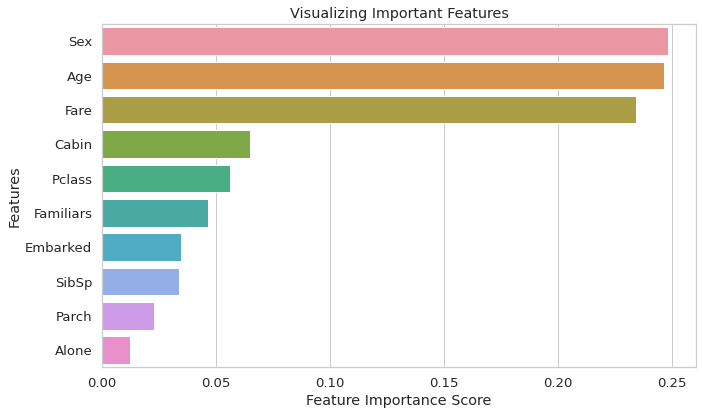

In [ ]:
feature_imp = pd.Series(clf.feature_importances_, index=scaled_train.columns).sort_values(ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

Após a visualização do gráfico, retiraremos as características menos importantes como o Parch e Alone, assim podemos ver se a precisão dos dados podem melhorar.

   Accuracy: 0.8212290502793296
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       113
           1       0.77      0.74      0.75        66

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Alone,Familiars,Survival_Predictions
0,3,0,34.5,0,0,7.8292,7,3,1,1,0
1,3,1,47.0,1,0,7.0000,7,1,0,2,0
2,2,0,62.0,0,0,9.6875,7,3,1,1,0
3,3,0,27.0,0,0,8.6625,7,1,1,1,1
4,3,1,22.0,1,1,12.2875,7,1,0,3,1


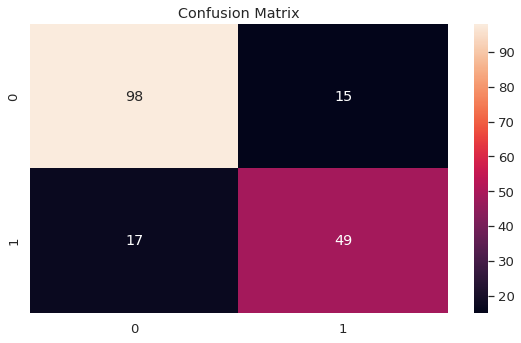

In [ ]:
new_train = scaled_train.drop(['Alone','Parch','Embarked'], axis=1)
new_test = scaled_test.drop(['Alone','Parch','Embarked'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(new_train, y, test_size=0.2)
clf = RandomForestClassifier(n_estimators=100)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("   Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))

print(classification_report(y_test,y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.tight_layout()

prediction = clf.predict(new_test)

test_data['Survival_Predictions'] = pd.Series(prediction)
test_data.head()

A precisão melhorou com a redução de características, o modelo pode identificar melhor os mortos do que sobreviventes, mas isso se deu porque havia maior número deles. Assim foi possível chegar na matriz de confusão e a previsão do nosso conjunto de dados.

A classificação dos sobreviventes foi de 85%, isso pois o conjunto de dados é muito pequeno. 